# Proyecto individual - Xavier Harry Vidman

### Para una correcta carga de las tablas, este archivo debe estar en la misma carpeta que los datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
sns.set()

compra = pd.read_csv('Compra.csv', delimiter=',')
gasto = pd.read_csv('Gasto.csv', delimiter=',')
localidad = pd.read_csv('Localidades.csv', delimiter=',')
proveedor = pd.read_csv('Proveedores.csv', delimiter=',', encoding='latin-1')
sucursal = pd.read_csv('Sucursales.csv', delimiter=';')
venta = pd.read_csv('Venta.csv', delimiter=',')

from os import listdir
path = r'C:\Users\Xavi\Desktop\PI_semana_1\DS-PI-ProyectoIndividual/Datasets'
files = listdir(path)

cliente_files = []
for file in files:
    if file.__contains__('Clientes'):
        cliente_files.append(file)

cliente = pd.concat((pd.read_csv(file, delimiter=';').assign(filename = file) for file in cliente_files), ignore_index=True)
cliente.drop(columns={'filename'}, inplace=True)

## Limpieza y normalización de cada tabla

### Tabla N°1: cliente

In [ ]:
#Normalizo nombre de columnas y dropeo duplicados
cliente.rename(columns={'ID':'Id_cliente', 'Nombre_y_Apellido':'Nombre_apellido'}, inplace=True)
cliente.drop_duplicates(inplace=True)

#Borro columnas intrascendentes
extra_fields = {'X', 'Y', 'col10'}
for col in cliente.columns:
    for i in extra_fields:
        if i == col:
            cliente.drop(columns={col}, inplace=True)
    
# Completamos valores nulos
for col in cliente.columns:
    cliente[col].replace(to_replace='Nan', value='Sin Dato', inplace=True)

 #Normalizo valores faltantes con el valor de 'Sin Dato'
for col in cliente.columns:
    for i,value in enumerate(cliente[col].isna()): #isna and isnull are the same, they are alias.
        if value == True:
            cliente[col][i] = 'Sin Dato'

#Normalizo datos strings
fields = ['Provincia', 'Nombre_apellido', 'Domicilio', 'Localidad']
for col in fields:
    for i,value in enumerate(cliente[col]):
        value = str(value)
        cliente[col][i] = value.title()


In [18]:
cliente.head(10)

,Id_cliente,Provincia,Nombre_apellido,Domicilio,Telefono,Edad,Localidad
0,1,Buenos Aires,Heber Joni Santana,Las Heras Y Bat. 24 De Febrero 4150 Rincon De...,42-5161,58,Loma Verde
1,2,Buenos Aires,Ana Sapriza,Pueyrredon Y Dupuy Ruta3 Km 52.500 S/N Bâº Lo...,49-7578,61,Santa Rosa
2,3,Buenos Aires,Fernando Luis Saralegui,Calderon De La Barca 498,49-3435,15,Torres
3,4,Buenos Aires,Manuela Sarasola,"Ruta 36 Km 45,500 S/N El Peligro",49-2883,29,Ruta Sol
4,5,Buenos Aires,Mario Raúl Sarasua,492 Y 186 S/N Colonia Urquiza,491-4608,34,Jose Melchor Romero
5,6,Buenos Aires,Pedro Jesus Saravia,"Ruta 2 - Km 44,500 S/N El Peligro",49-2350,18,Ruta Sol
6,7,Buenos Aires,Jorge Saravia,Villarroel Ruta 3 Km 46500 S/N Barrio San Mar...,49-5306,21,Virrey Del Pino
7,8,Buenos Aires,Carlos Jose Sarazola,Isla Santiago S/N Isla Santiago,623-9935,40,Isla Santiago
8,9,Buenos Aires,Oscar Luis Sarlo,Garcilazo De La Vega Y San Martin S/N Santa Rosa,49-7576,18,Santa Rosa
9,10,Buenos Aires,Jose Adolfo Sarmiento,Segundo Sombra E/Magallanes Y P. Galdo S/N Sa...,49-7565,58,Santa Rosa


### Tabla N°2: compra

In [ ]:
#Dropeamos duplicados y renames de columnas
compra.drop_duplicates(inplace=True)
compra.rename(columns={'IdCompra':'Id_compra', 'Fecha_Año': 'Fecha_año', 'Fecha_Mes':'Fecha_mes', 'Fecha_Periodo':'Fecha_periodo'}, inplace=True)
compra.rename(columns={'IdProducto':'Id_producto', 'IdProveedor': 'Id_proveedor'}, inplace=True)


#Arreglamos los datos de la columna Fecha y Fecha_periodo
compra['Fecha'] = pd.to_datetime(arg=compra['Fecha'])
for i in range(0, len(compra['Fecha_periodo'])):
    compra['Fecha_periodo'][i] = str(compra['Fecha_periodo'][i])
    if compra['Fecha_periodo'][i] != compra['Fecha_periodo'][i][:4] + '-' + compra['Fecha_periodo'][i][4:]:
        compra['Fecha_periodo'][i] = compra['Fecha_periodo'][i][:4] + '-' + compra['Fecha_periodo'][i][4:]


#Creo lista de Id_productos no duplicados
id_prod = compra['Id_producto'].drop_duplicates()
id_prod.sort_values(ascending=True, inplace=True)

#Creo lista con la media del precio de cada producto
mean_prod = compra.groupby('Id_producto')['Precio'].mean()
mean_prod = list(mean_prod)

#Creo lista con la desviación estándar del precio de cada producto
std_prod = compra.groupby('Id_producto')['Precio'].std()
std_prod = list(std_prod)

#Creo dataframe auxiliar con las 3 listas anteriores
df_aux = pd.DataFrame({'id_prod':id_prod, 'mean_precio':mean_prod, 'std_prod':std_prod})
df_aux.reset_index(inplace=True)
df_aux.drop(columns={'index'}, inplace=True)

#Creo lista de outliers
outliers_id_prod = [] 
outliers_precio = []

#Agregamos outliers:
for i in range(0, len(compra['Precio'])):
    for j in range(0, len(df_aux['id_prod'])):
        if compra['Id_producto'][i]==df_aux['id_prod'][j]:
            if compra['Precio'][i] < df_aux['mean_precio'][j] - 3*df_aux['std_prod'][j] or compra['Precio'][i] > df_aux['mean_precio'][j] + 3*df_aux['std_prod'][j]:
                outliers_id_prod.append(compra['Id_producto'][i])
                outliers_precio.append(compra['Precio'][i])
                
#Agregamos valores nulos a las lista de outliers:
for i,value in enumerate(compra['Precio'].isna()):
    if value == True:
        outliers_id_prod.append(compra['Id_producto'][i])
        outliers_precio.append(compra['Precio'][i])

#Creamos un dataframe de datos "no confiables" con todos los outliers y valores nulos
dato_compra_nc = pd.DataFrame({'id_prod':outliers_id_prod, 'Precio':outliers_precio})

### Graficamos los datos confiables y no confiables

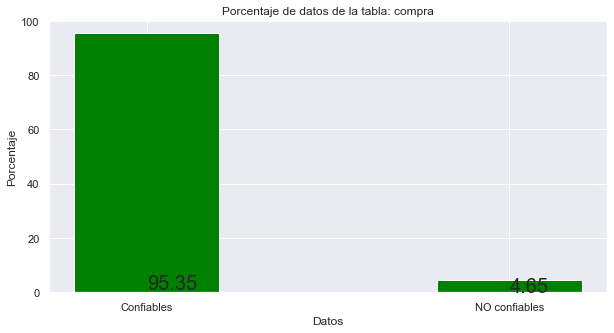

In [90]:
num_total = len(compra['Id_compra'])
num_outlier = len(dato_compra_nc['id_prod'])
per_confiable = round((num_total - num_outlier)*100/num_total,2)
per_outlier = round(100 - per_confiable,2)

data = {'Confiables':per_confiable, 'NO confiables':per_outlier}

keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(keys, values, color ='green',
        width = 0.4)
 
plt.text(0,1,per_confiable, fontsize=20) 
plt.text(1,0,per_outlier, fontsize=20) 
plt.xlabel("Datos")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de datos de la tabla: compra")
plt.show()



### Quitamos valores no confiables de la tabla compra, es decir, valores nulos y outliers.

In [20]:
for i,value in enumerate(compra['Precio'].isna()):
    if value == True:
        compra.drop(axis=0, index=i, inplace=True)
compra.reset_index(inplace=True)
compra.drop(columns={'index'}, inplace=True)

for i,value1 in enumerate(compra['Precio']):
    for j,value2 in enumerate(outliers_precio):
        if value1==value2:
            compra.drop(axis=0, index=i, inplace=True)
compra.reset_index(inplace=True)
compra.drop(columns={'index'}, inplace=True)

In [21]:
compra.head(10)

,Id_compra,Fecha,Fecha_año,Fecha_mes,Fecha_periodo,Id_producto,Cantidad,Precio,Id_proveedor
0,1,2015-01-30,2015,1,2015-01,42832,13,560.51,12
1,2,2015-01-30,2015,1,2015-01,42833,11,497.58,7
2,3,2015-01-30,2015,1,2015-01,42834,1,588.50,6
3,4,2015-01-30,2015,1,2015-01,42835,9,567.66,14
4,5,2015-01-30,2015,1,2015-01,42839,14,231.31,2
5,6,2015-01-30,2015,1,2015-01,42840,14,232.07,13
6,7,2015-01-30,2015,1,2015-01,42841,8,236.98,4
7,8,2015-01-30,2015,1,2015-01,42842,4,255.33,4
8,9,2015-01-30,2015,1,2015-01,42845,5,578.61,12
9,10,2015-01-30,2015,1,2015-01,42855,1,809.04,6


### Tabla N°3: gasto

In [22]:
gasto.drop_duplicates(inplace=True)
gasto.rename(columns={'IdGasto':'Id_gasto', 'IdSucursal':'Id_sucursal', 'IdTipoGasto':'Id_tipo_gasto'}, inplace=True)

gasto.head(10)


,Id_gasto,Id_sucursal,Id_tipo_gasto,Fecha,Monto
0,1,18,1,2015-01-01,1164.90
1,2,18,2,2015-01-01,317.02
2,3,18,3,2015-01-01,118.89
3,4,18,4,2015-01-01,1174.23
4,5,1,1,2015-01-01,1104.51
5,6,1,2,2015-01-01,359.96
6,7,1,3,2015-01-01,108.59
7,8,1,4,2015-01-01,1029.69
8,9,2,1,2015-01-01,1090.87
9,10,2,2,2015-01-01,349.58


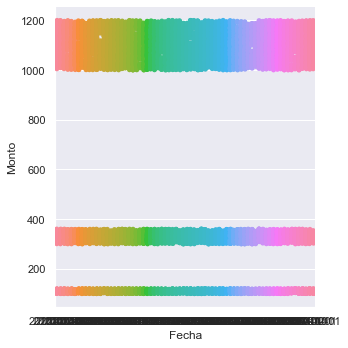

In [112]:
sns.catplot(x='Fecha', y='Monto', data=gasto)

### Tabla N°4: localidad

In [ ]:
#Dropeo columnas intrascendentes
extra_fields = {'centroide_lat', 'centroide_lon'}
for col in localidad.columns:
    for i in extra_fields:
        if i == col:
            localidad.drop(columns={col}, inplace=True)

#renames de columnas
localidad.rename(columns={'categoria':'Categoria', 'departamento_id':'Id_departamento', 'departamento_nombre':'Departamento'}, inplace=True)
localidad.rename(columns={'fuente':'Fuente', 'id':'Id_localidad', 'localidad_censal_id':'Id_localidad_censal'}, inplace=True)
localidad.rename(columns={'localidad_censal_nombre':'Localidad_censal', 'municipio_id':'Id_municipio', 'municipio_nombre':'Municipio'}, inplace=True)
localidad.rename(columns={'nombre':'Localidad', 'provincia_id':'Id_provincia', 'provincia_nombre':'Provincia'}, inplace=True)

#Completo valores nulos
for col in localidad.columns:
    for i,value in enumerate(localidad[col].isna()): #isna and isnull are the same, they are alias.
        if value == True:
            localidad[col][i] = 'Sin Dato'

#Normalizo datos strings
fields = ['Departamento', 'Localidad_censal', 'Municipio', 'Localidad'] #ver que hay que capitalize() y que title()
for col in fields:
    for i,value in enumerate(localidad[col]):
        value = str(value)
        localidad[col][i] = value.title()

In [24]:
localidad.head(10)

,Categoria,Id_departamento,Departamento,Fuente,Id_localidad,Id_localidad_censal,Localidad_censal,Id_municipio,Municipio,Localidad,Id_provincia,Provincia
0,Localidad simple,6021.0,Alberti,INDEC,6021010000,6021010,Alberti,60021.0,Alberti,Alberti,6,Buenos Aires
1,Localidad simple,6021.0,Alberti,INDEC,6021020000,6021020,Coronel Seguí,60021.0,Alberti,Coronel Segui,6,Buenos Aires
2,Componente de localidad compuesta,6021.0,Alberti,INDEC,6021030000,6021030,Mechita,60021.0,Alberti,Mechita,6,Buenos Aires
3,Localidad simple,6021.0,Alberti,INDEC,6021040000,6021040,Pla,60021.0,Alberti,Pla,6,Buenos Aires
4,Localidad simple,6021.0,Alberti,INDEC,6021050000,6021050,Villa Grisolía,60021.0,Alberti,Villa Grisolia,6,Buenos Aires
5,Localidad simple,6021.0,Alberti,INDEC,6021060000,6021060,Villa María,60021.0,Alberti,Villa Maria,6,Buenos Aires
6,Localidad simple,6021.0,Alberti,INDEC,6021070000,6021070,Villa Ortiz,60021.0,Alberti,Villa Ortiz,6,Buenos Aires
7,Entidad,6028.0,Almirante Brown,INDEC,6028010001,6028010,Almirante Brown,60028.0,Almirante Brown,Adrogue,6,Buenos Aires
8,Entidad,6028.0,Almirante Brown,INDEC,6028010002,6028010,Almirante Brown,60028.0,Almirante Brown,Burzaco,6,Buenos Aires
9,Entidad,6028.0,Almirante Brown,INDEC,6028010003,6028010,Almirante Brown,60028.0,Almirante Brown,Claypole,6,Buenos Aires


### Tabla N°5: sucursal

In [ ]:
#Dropeo columnas intrascendentes
extra_fields = {'Latitud', 'Longitud'}
for col in sucursal.columns:
    for i in extra_fields:
        if i == col:
            sucursal.drop(columns={col}, inplace=True)

sucursal.rename(columns={'ID':'Id_sucursal'}, inplace=True)

#Normalizo los strings
fields = ['Sucursal', 'Direccion', 'Localidad', 'Provincia']
for col in fields:
    for i,value in enumerate(sucursal[col]):
        value = str(value)
        sucursal[col][i] = value.title()

#Normalizo datos mal ingresados de la columna: Localidad
for i,loc in enumerate(sucursal['Localidad']):
    if loc=='Cordoba' or loc=='Coroba':
        sucursal['Localidad'][i] = 'Córdoba'
    if loc.__contains__('Cap')==True and loc.__contains__('Fed')==True:
        sucursal['Localidad'][i] = 'Capital Federal'
    if loc.__contains__('Buenos Aires')==True or loc.__contains__('Caba')==True or loc=='Capital' or loc.__contains__('Capfed')==True:
        sucursal['Localidad'][i] = 'Capital Federal'

#Normalizo datos mal ingresados de la columna: Provincia
for i,prov in enumerate(sucursal['Provincia']):
    if prov.__contains__('Aires')==True or prov.__contains__('Buenos') or prov.__contains__('Caba')==True or prov.__contains__('Bs')==True or prov.__contains__('As')==True:
        sucursal['Provincia'][i] = 'Buenos Aires'
    if prov.__contains__('rdoba'):
        sucursal['Provincia'][i] = 'Córdoba'

In [26]:
sucursal.head(10)

,Id_sucursal,Sucursal,Direccion,Localidad,Provincia
0,1,Cabildo,Av. Cabildo 1342,Capital Federal,Buenos Aires
1,2,Palermo 1,Guatemala 5701,Capital Federal,Buenos Aires
2,3,Palermo 2,Gral. Lucio Norberto Mansilla 2668,Capital Federal,Buenos Aires
3,4,Corrientes,Av. Corrientes 2352,Capital Federal,Buenos Aires
4,5,Almagro,Venezuela 3650,Capital Federal,Buenos Aires
5,6,Caballito,Av. Rivadavia 4708,Capital Federal,Buenos Aires
6,7,Flores,Av. Rivadavia 5746,Capital Federal,Buenos Aires
7,8,Alberdi,Av. Juan Bautista Alberdi 1634,Capital Federal,Buenos Aires
8,9,Deposito,Pedernera 530,Capital Federal,Buenos Aires
9,10,Velez,Av. Juan Bautista Justo 7738,Capital Federal,Buenos Aires


### Tabla N°6: venta

In [2]:
venta.drop_duplicates(inplace=True)
venta.rename(columns={'IdVenta':'Id_venta', 'Fecha_Entrega':'Fecha_entrega', 'IdCanal':'Id_canal', 'IdCliente':'Id_cliente', 'IdSucursal':'Id_sucursal'}, inplace=True)
venta.rename(columns={'IdEmpleado':'Id_empleado', 'IdProducto':'Id_producto'}, inplace=True)

#Creo lista de Id_productos no duplicados
id_prod = venta['Id_producto'].drop_duplicates()
id_prod.sort_values(ascending=True, inplace=True)

#Creo lista con la media del precio de cada producto
mean_prod = venta.groupby('Id_producto')['Precio'].mean()
mean_prod = list(mean_prod)

#Creo lista con la desviación estándar del precio de cada producto
std_prod = venta.groupby('Id_producto')['Precio'].std()
std_prod = list(std_prod)

#Creo dataframe auxiliar con las 3 listas anteriores
df_aux = pd.DataFrame({'id_prod':id_prod, 'mean_precio':mean_prod, 'std_prod':std_prod})
df_aux.reset_index(inplace=True)
df_aux.drop(columns={'index'}, inplace=True)

#Creo lista de outliers
outliers_id_prod = [] 
outliers_precio = []

#Agregamos outliers:
for i in range(0, len(venta['Precio'])):
    for j in range(0, len(df_aux['id_prod'])):
        if venta['Id_producto'][i]==df_aux['id_prod'][j]:
            if venta['Precio'][i] < df_aux['mean_precio'][j] - 3*df_aux['std_prod'][j] or venta['Precio'][i] > df_aux['mean_precio'][j] + 3*df_aux['std_prod'][j]:
                outliers_id_prod.append(venta['Id_producto'][i])
                outliers_precio.append(venta['Precio'][i])
                
#Agregamos valores nulos a las lista de outliers:
for i,value in enumerate(venta['Precio'].isna()):
    if value == True:
        outliers_id_prod.append(venta['Id_producto'][i])
        outliers_precio.append(venta['Precio'][i])

#Creamos un dataframe de datos "no confiables" con todos los outliers y valores nulos
dato_venta_nc = pd.DataFrame({'id_prod':outliers_id_prod, 'Precio':outliers_precio})

### Graficamos los datos confiables y no confiables

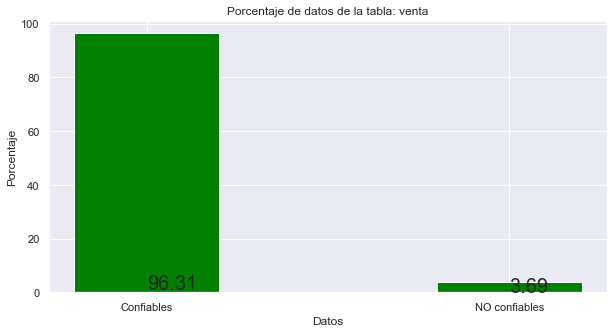

In [3]:
num_total = len(venta['Id_venta'])
num_outlier = len(dato_venta_nc['id_prod'])
per_confiable = round((num_total - num_outlier)*100/num_total,2)
per_outlier = round(100 - per_confiable,2)

data = {'Confiables':per_confiable, 'NO confiables':per_outlier}

keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(keys, values, color ='green',
        width = 0.4)
 
plt.text(0,1,per_confiable, fontsize=20) 
plt.text(1,0,per_outlier, fontsize=20) 
plt.xlabel("Datos")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de datos de la tabla: venta")
plt.show()

### Quitamos valores no confiables de la tabla venta, es decir, valores nulos y outliers.

In [ ]:
venta.reset_index(inplace=True)
venta.drop(columns={'index'}, inplace=True)

for i,value in enumerate(venta['Precio'].isna()):
    if value == True:
        venta.drop(axis=0, index=i, inplace=True)
        
venta.reset_index(inplace=True)
venta.drop(columns={'index'}, inplace=True)

for i in range(0, len(venta['Precio'])):
    for value2 in dato_venta_nc:
        if venta['Precio'][i]==value2:
            venta.drop(axis=0, index=i, inplace=True)
    
venta.reset_index(inplace=True)
venta.drop(columns={'index'}, inplace=True)

In [10]:
venta.head(10)

,Id_venta,Fecha,Fecha_entrega,Id_canal,Id_cliente,Id_sucursal,Id_empleado,Id_producto,Precio,Cantidad
0,1,2018-03-09,2018-03-17,3,969,13,1674,42817,813.12,2.0
1,2,2018-12-28,2018-12-29,2,884,13,1674,42795,543.18,3.0
2,3,2016-03-28,2016-03-31,2,1722,13,1674,42837,430.32,1.0
3,4,2017-10-23,2017-10-24,3,2876,13,1674,42834,818.84,2.0
4,5,2017-11-22,2017-11-25,2,678,13,1674,42825,554.18,3.0
5,6,2018-01-24,2018-01-25,2,3263,13,1674,42852,152.00,1.0
6,7,2015-03-25,2015-03-26,3,2983,13,1674,42939,2915.00,1.0
7,8,2017-07-10,2017-07-18,2,201,13,1674,42940,2162.00,2.0
8,9,2018-04-03,2018-04-06,2,1006,13,1674,42905,456.00,3.0
9,10,2019-03-16,2019-03-17,1,1003,13,1674,42894,515.00,2.0


### Tabla N°7: proveedor

In [ ]:
proveedor.drop_duplicates(inplace=True)
proveedor.rename(columns={'IDProveedor':'Id_proveedor', 'Address':'Domicilio', 'City':'Ciudad', 'State':'Provincia', 'Country':'Pais', 'departamen':'Departamento'}, inplace=True)

#Normalizo los strings
fields = ['Nombre', 'Domicilio', 'Ciudad', 'Provincia', 'Pais', 'Departamento']
for col in fields:
    for i,value in enumerate(proveedor[col]):
        value = str(value)
        proveedor[col][i] = value.title()

#Normalizo valores faltantes con el valor de 'Sin Dato'
for col in proveedor.columns:
    proveedor[col].replace(to_replace='Nan', value='Sin Dato', inplace=True)

#Normalizo datos mal ingresados de la columna: Provincia
for i,prov in enumerate(proveedor['Provincia']):
    if prov.__contains__('Aires')==True or prov.__contains__('Buenos') or prov.__contains__('Caba')==True or prov.__contains__('Bs')==True or prov.__contains__('As')==True:
        proveedor['Provincia'][i] = 'Buenos Aires'
    if prov.__contains__('rdoba'):
        proveedor['Provincia'][i] = 'Córdoba'



In [46]:
proveedor.head(10)

,Id_proveedor,Nombre,Domicilio,Ciudad,Provincia,Pais,Departamento
0,1,Sin Dato,Bereguestein 36,Avellaneda,Buenos Aires,Argentina,Avellaneda
1,2,San Cirano,Alberti 965,Coronel Brandsen,Buenos Aires,Argentina,Brandsen
2,3,Bell S.A.,Moreno 331,Campana,Buenos Aires,Argentina,Campana
3,4,Rivero Insumos,Pte. Peron 3872,Valentin Alsina,Buenos Aires,Argentina,Lanus
4,5,Laprida Computacion,Avda. Pedro Pereyra 1339,Laprida,Buenos Aires,Argentina,Laprida
5,6,Importadora Mann Kloss,Lope De Vega 2102,Boca De Atencion Monte Castro,Buenos Aires,Argentina,Comuna 10
6,7,Fletes Y Logistica,Santa Rosa 1564,Cordoba,Córdoba,Argentina,Capital
7,8,Sin Dato,Santa Rosa 1564,Cordoba,Córdoba,Argentina,Capital
8,9,Via Chile Containers,Juan B. Justo 415,Mendoza,Mendoza,Argentina,Capital
9,10,Full Toner,Cordoba 246,Mendoza,Mendoza,Argentina,Capital
